<div align="right" style="text-align: right;"><i>Peter Norvig<br>Jotto: April 2020<br>Wordle: Jan 2022<br>Evil/Anti: Nov 2022</i></div>

# Wordle, Evil Wordle, Antiwordle, and Jotto

[**Wordle**](https://www.nytimes.com/games/wordle/index.html) is Josh Wardle's [tremendously popular](https://www.nytimes.com/2022/01/03/technology/wordle-word-game-creator.html) word game in which a **guesser** tries to guess a secret **target** word (chosen from a **word list** of allowable words) in as few guesses as possible. Each guess must be one of the words on the list, and the **reply** to each guess consists of 5 bits (actually [trits](https://en.wiktionary.org/wiki/trit#English)) of information, one for each of the 5 word spots:
  - *Green* if the guess letter is in the word and in the correct spot.
  - *Yellow* if the guess letter is in the word but in the wrong spot.
  - *Miss* if the letter is not in the word in any spot.

Wordle uses a list of 12,971 allowable guess words, but only 2,309 of them can be target words. (I think the idea is to follow [Postel's law](https://en.wikipedia.org/wiki/Robustness_principle): "be conservative in what you send, be liberal in what you accept".) In this notebook, we'll assume we're only dealing with the 2,309 target words. Historically, Wordle is a refinement of **Jotto**, and has in turn inspired variants inclusding **Evil Wordle** and **Antiwordle**, all of which we will cover in this notebook.

First off, import some modules and define the basic types `Word`, `Score`, and `Reply`, and the colors that make up the reply:

In [1]:
from typing      import List, Tuple, Dict, Union, Counter, Callable, Iterable
from dataclasses import dataclass
from statistics  import mean, median, stdev
from collections import defaultdict
from functools   import lru_cache
from pathlib     import Path
from math        import log2
import random 
import matplotlib.pyplot as plt

Word  = str # A word is a string of five different letters
Score = int # A score is the number of guesses it took to get the target word
Reply = str # A reply is a str of 5 characters from Green, Yellow, Miss; e.g. 'G...Y'

Green, Yellow, Miss = 'GY.'
Correct = 5 * Green # The reply for the correct guess

random.seed('for reproducibility')

Now read in the word list:

In [2]:
! [ -e wordle-small.txt ] || curl -O https://norvig.com/ngrams/wordle-small.txt

wordlist = Path('wordle-small.txt').read_text().split()

assert len(wordlist) == 2309

# Replies

The rules for Wordle replies, outlined above, contain an ambiguity. Let's clear things up.

Assume the guess is `'NINNY'` and the target is `'ANNEX'`. A strict reading of the rules would say that the reply should be `'Y.GY.'`–one of the three `'N'`s is in the right spot and thus is green, and the other two should be yellow  because they are  "in the word but in the wrong spot." But the actual (unstated) rules are that Wordle matches the greens first, and then goes left-to-right with the yellows, and only gives you as many non-misses as there are letters in the target to support them. In this example, there are two `'N'`s in the target, so after the one green, there will only be one more yellow `'N'`, and it will be in the leftmost available spot. The actual reply is `'Y.G..'`.

In general, how many possible replies are there? There are 3 responses at each of five positions, and  3<sup>5</sup> = 243, but five of those replies are impossible: you can't have four Greens and one Yellow, because if four letters of the guess are in the right place then the fifth must be either in the right place or a miss. 

Below is the definition of `reply_for` and some tests. Note that `reply_for` is not symmetric; `reply_for(A, B)` is always a permutation of `reply_for(B, A)`, but they are usually not equal. Since the computation of a reply is somewhat complex, we cache the results.


In [3]:
@lru_cache(None)
def reply_for(guess: Word, target: Word) -> Reply: 
    "The five-character reply for this guess on this target."
    # We'll start by having each element of the reply be either Green or Miss ...
    reply = [Green if guess[i] == target[i] else Miss for i in range(5)]
    # ... then we'll change the elements that should be yellow
    counts = Counter(target[i] for i in range(5) if guess[i] != target[i])
    for i in range(5):
        if reply[i] == Miss and counts[guess[i]] > 0:
            counts[guess[i]] -= 1
            reply[i] = Yellow
    return ''.join(reply)

In [4]:
assert reply_for('NINNY', 'ANNEX') == 'Y.G..'; assert  reply_for('ANNEX', 'NINNY') == '.YG..'
assert reply_for('HELLO', 'WORLD') == '...GY'; assert  reply_for('WORLD', 'HELLO') == '.Y.G.'
assert reply_for('HELLO', 'ABYSS') == '.....'; assert  reply_for('ABYSS', 'HELLO') == '.....'
assert reply_for('EPEES', 'GEESE') == 'Y.GYY'; assert  reply_for('GEESE', 'EPEES') == '.YGYY'
assert reply_for('WHEEE', 'PEEVE') == '..GYG'; assert  reply_for('PEEVE', 'WHEEE') == '.YG.G'

# Consistent Target Words

A key concept in Wordle is the idea of **consistent target words**. If I guess `'NINNY'` and the reply is `'Y.G..'`, then the target word could be `'ANNEX'`, but it could also be `'ANNUL'` or `'CANON'`. We say these three words are **consistent** with the guess/reply pair.  If we next guess `'ENNUI'` and get the reply `'YGG..'`, then `'ANNEX'` is the only consistent target. When there is a single consistent target left, the guesser can always get it on the next guess. In general, given a word list, I can always determine the list of consistent targets from a sequence of guess/reply pairs. Once I know the consistent words, the guess/reply pairs themselves provide no additional useful information.  

In [5]:
def consistent_targets(targets, guess, reply) -> List[Word]: 
    """All the words in `targets` that give this `reply` to this `guess`."""
    return [target for target in targets if reply_for(guess, target) == reply]

targets = consistent_targets(wordlist, 'NINNY', 'Y.G..')
assert  targets == ['ANNEX', 'ANNUL', 'CANON']
assert  consistent_targets(targets, 'ENNUI', 'YGG..') == ['ANNEX']

# Playing Wordle

The function `play` will play a game of Wordle and return the score (the number of guesses). The  arguments are:
- `guesser`: a `callable` (e.g., a function) that should return the guess to make. The guesser is passed two arguments: 
  - The **reply** to the previous guess.
  - A list of **consistent target words**.
- `wordlist`: The list of allowable words.
- `target`: The target word. If none is given, the target word is chosen at random from the wordlist.
- `verbose`: Unless false, print a message for each guess.

Two corner cases: 
1. If the guesser improperly guesses a non-word, the reply is `'unknown'`. 
2. To prevent an infinite loop with a bad guesser, the worst score you can get is the number of words in the wordlist plus 1.

In [6]:
def play(guesser, wordlist=wordlist, target=None, verbose=True) -> Score:
    """The number of guesses it take for `guesser` to guess the Jotto word,
    which is given by `target` or selected from the words in `wordlist`?"""
    target  = target or random.choice(wordlist) # Choose a random target if none was given
    targets = wordlist      # The targets that are consistent with all guess/reply pairs
    reply   = None          # For the first guess, there is no previous reply
    N       = len(wordlist)
    for turn in range(1, N + 1):
        guess   = guesser(reply, targets)
        reply   = reply_for(guess, target) if guess in wordlist else 'unknown'
        targets = consistent_targets(targets, guess, reply)
        if verbose: 
            print(f'Guess {turn}: {guess}, Reply: {reply}; Remaining targets: {len(targets)}')
        if reply == Correct:  
            return turn
    return N + 1

To play a game, we will need a guesser. Here are two simple ones:


In [7]:
def human_guesser(reply, targets) -> Word: 
    """Ask a human to make a guess."""
    return input(f'Reply was {reply}. Your guess? ')

def random_guesser(reply, targets) -> Word: 
    """Choose a guess at random from the consistent targets."""
    return random.choice(targets)

# Sample Wordle Games

Here is the `random_guesser` in action:

In [8]:
play(random_guesser)

Guess 1: VALUE, Reply: .....; Remaining targets: 313
Guess 2: NOTCH, Reply: .Y...; Remaining targets: 21
Guess 3: PROXY, Reply: YGG..; Remaining targets: 1
Guess 4: DROOP, Reply: GGGGG; Remaining targets: 1


4

In [9]:
play(random_guesser)

Guess 1: SLAIN, Reply: ....G; Remaining targets: 25
Guess 2: TOKEN, Reply: ....G; Remaining targets: 1
Guess 3: CHURN, Reply: GGGGG; Remaining targets: 1


3

In [10]:
play(random_guesser, target='HELLO')

Guess 1: SMOKE, Reply: ..Y.Y; Remaining targets: 64
Guess 2: VOWEL, Reply: .Y.YY; Remaining targets: 3
Guess 3: FELON, Reply: .GGY.; Remaining targets: 2
Guess 4: CELLO, Reply: .GGGG; Remaining targets: 1
Guess 5: HELLO, Reply: GGGGG; Remaining targets: 1


5

#  Partitioning Target Words

We can think of a guess as **partitioning** the consistent targets into different **branches** of a tree, each branch corresponding to a different reply:

In [11]:
Partition = Dict[Reply, List[str]]

def partition(guess, targets) ->  Partition:
    """A guess partition targets by the possible replies to guess: {reply: [word, ...]}."""
    branches = defaultdict(list)
    for target in targets:
        branches[reply_for(guess, target)].append(target)
    return branches

A partition for the full wordlist would be too big to look at, so let's pick out a few words (every 100th one, so that's 24 words), and partition them by two different guesses. First, the few words partitioned by `'ROAST'`:

In [12]:
few = wordlist[::100]

partition('ROAST', few)

defaultdict(list,
            {'..G..': ['ABACK', 'QUACK'],
             'YYY..': ['ARBOR'],
             'Y...Y': ['BIRTH', 'TREND'],
             '.....': ['BULLY', 'CUMIN'],
             '..GG.': ['CLASP', 'PHASE'],
             'YY...': ['DROOL', 'HUMOR'],
             '..Y..': ['FANCY', 'NINJA'],
             'Y.G..': ['FRANK'],
             'Y.G.Y': ['GRATE'],
             'Y.Y.Y': ['LATER'],
             '.YYY.': ['MASON'],
             'GGGGG': ['ROAST'],
             '..GY.': ['SHALE'],
             '...Y.': ['SMELL'],
             '..GYY': ['STAMP'],
             '..Y.Y': ['TAKEN'],
             'Y.Y..': ['VIRAL'],
             '..Y.G': ['YACHT']})

No matter what the reply to `'ROAST'` is,  we will be left with no more than 2 remaining possible targets, so we will always be able to win in no more than 3 total guesses. Now, partition by  `'NINJA'`:



In [13]:
partition('NINJA', few)

defaultdict(list,
            {'....Y': ['ABACK',
              'ARBOR',
              'CLASP',
              'GRATE',
              'LATER',
              'PHASE',
              'QUACK',
              'ROAST',
              'SHALE',
              'STAMP',
              'YACHT'],
             '.G...': ['BIRTH'],
             '.....': ['BULLY', 'DROOL', 'HUMOR', 'SMELL'],
             'YY...': ['CUMIN'],
             '..G.Y': ['FANCY'],
             'Y...Y': ['FRANK', 'MASON', 'TAKEN'],
             'GGGGG': ['NINJA'],
             'Y....': ['TREND'],
             '.G..Y': ['VIRAL']})

Almost half the time we get a reply of `'....Y'`, and there are 11 possible target words remaining. That  suggests that `'ROAST'` is a better guess and that a good strategy is: **guess a word that partitions the possible remaining targets into small branches.**

To do this we only need to know the *size* of each branch, not the list of words therein, so we could use `partition_counts`:

In [14]:
def partition_counts(guess, targets) -> List[int]: 
    "The sizes of the branches of a partition of targets by guess."
    counter = Counter(reply_for(guess, target) for target in targets)
    return sorted(counter.values())

In [15]:
assert partition_counts('ROAST', few) == [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
assert partition_counts('NINJA', few) == [1, 1, 1, 1, 1, 1, 3, 4, 11]

# Metrics for Minimizing Partitions

We want partitions with **small branches**, but what exactly does that mean? An ideal goal would be to minimize the average number of additional guesses it will take to finish the game, and to eliminate the possibility of losing the game (needing more than 6 guesses). However, just looking at a single partition (without looking ahead further) can't tell us that, so instead we can minimize one of the following proxy metrics:

- **Maximum**: choose the partition that minimizes the size of the largest branch.

- **Expectation**: In probability theory, the expectation (also known as expected value) is the weighted average of a random variable. Here it means the sum, over all branches, of the probability of ending up in the branch multiplied by the size of the branch. We are assuming that every target is equally likely, so the probability of a branch is proportional to the number of targets in it.

- **Negative Entropy**: In information theory, entropy is the weighted average amount of "information" measured in bits. The calculation is the same as expectation except that we count the base 2 logarithm of the branch sizes, not the branches sizes themselves. You can think of the base 2 logarithm as the number of times that you need to cut a branch in half to get it down to one word. We want to maximize entropy, or minimize *negative* entropy.

The maximum is just the builtin `max` function; here are the other two metrics:

In [16]:
def expectation(counts: List[int]) -> float:
    "The expected value of the counts."
    N = sum(counts)
    def P(x): return x / N
    return sum(P(x) * x for x in counts)

def neg_entropy(counts: List[int]) -> float: 
    """The negation of the entropy of the counts."""
    N = sum(counts)
    def P(x): return x / N
    return sum(P(x) * log2(P(x)) for x in counts)

#  Caching Best Guesses: Guess Trees

Going through every word in the wordlist to decide which one makes the best partition takes some time. I would prefer to do that computation just once and cache it, rather than have to repeat the computation in every new game. I will cache the best guesses in a structure called a **guess tree**: a tree that has branches for every possible path the game might take, with the best guess for each situation precomputed. Some people call this a **policy**: a guideline that tells you what to do in any situation. A guess tree is either:
- An **interior node**, which has a guess and a dict of branches, `Node(guess, {reply: subtree, ...})`, where  each subtree covers all the target words that are consistent with the corresponding reply.
- A **leaf word**,  indicating the sole remaining consistent target word. Every word in the word list appears as a leaf in exactly one place in the tree.

In [17]:
@dataclass 
class Node:
    """A node in a guess tree stores the best guess, the number of targets covered, and a branch for every reply."""
    guess: Word
    size: int
    branches: Dict[Reply, 'Tree']

Tree = Union[Node, Word] # A Tree is either an interior Node or a leaf Word

The function `minimizing_tree(metric, targets)` builds a guess tree that covers all the targets and that, at every node, guesses a word that  minimizes the `metric` applied to the `partition_counts` of the guess.

In [18]:
def minimizing_tree(metric, targets) -> Tree:
    """Make a tree that picks guesses that minimize metric(partition_counts(guess, targets))."""
    if len(targets) == 1:
        return targets[0]
    else:
        guess = min(targets, key=lambda guess: metric(partition_counts(guess, targets))) 
        branches = partition(guess, targets)
        return Node(guess, len(targets), 
                    {reply: minimizing_tree(metric, branches[reply]) 
                     for reply in branches})

Here is a minimizing tree that covers the 24 `few` words. The tree says that the first guess, `"ROAST"`, covers 24 target words, and for 12 replies there is only one word left, but for the first 6 replies a second guess is required (e.g., if the reply is `'..G..` then the second guess is `"ABACK"`). Either that second guess will be right, or we will need a third guess (in this example, `'QUACK'`).

In [19]:
assert (minimizing_tree(max, few) == 
    Node("ROAST", 24,
         {'..G..': Node("ABACK", 2, {'GGGGG': 'ABACK', '..GGG': 'QUACK'}), 
          'Y...Y': Node("BIRTH", 2, {'GGGGG': 'BIRTH', '..YY.': 'TREND'}), 
          '.....': Node("BULLY", 2, {'GGGGG': 'BULLY', '.G...': 'CUMIN'}), 
          '..GG.': Node("CLASP", 2, {'GGGGG': 'CLASP', '..GGY': 'PHASE'}), 
          'YY...': Node("DROOL", 2, {'GGGGG': 'DROOL', '.Y.G.': 'HUMOR'}), 
          '..Y..': Node("FANCY", 2, {'GGGGG': 'FANCY', '.YG..': 'NINJA'}), 
          'YYY..': 'ARBOR', 
          'Y.G..': 'FRANK', 
          'Y.G.Y': 'GRATE', 
          'Y.Y.Y': 'LATER', 
          '.YYY.': 'MASON', 
          'GGGGG': 'ROAST', 
          '..GY.': 'SHALE', 
          '...Y.': 'SMELL', 
          '..GYY': 'STAMP', 
          '..Y.Y': 'TAKEN', 
          'Y.Y..': 'VIRAL', 
          '..Y.G': 'YACHT'}))

# Turning a Tree into a Guesser

A tree is not a guesser, but we can easily make a guesser from a tree. A `TreeGuesser` works as follows:
- When *initialized*, it takes a tree as input, and stores the tree under the `.root` attribute.
- When *called*, it first sets the `.tree` attribute as follows:
  - For the first turn in a game (when the reply is `None`), it resets `.tree`  to `.root`.
  - On subsequent turns, it updates `.tree` to be the branch corresponding to the reply.
  - After setting `.tree`, it returns the guess for the current tree: either the `.guess` attribute  or the leaf word. 

In [20]:
class TreeGuesser:
    """Given a guess tree, use it to create a callable Guesser that can play Wordle."""
    def __init__(self, tree): self.root = tree
        
    def __call__(self, reply, targets) -> Word:
        """If reply is `None`, start a new game; otherwise follow the branch for the `reply`.
        Then return the current leaf or interior node guess. (Ignore `targets`.)"""
        self.tree = self.root if reply is None else self.tree.branches[reply]
        return self.tree.guess if isinstance(self.tree, Node) else self.tree

Here we build a tree that minimizes the maximum branch size (over the full wordlist) and make a guesser out of it:

In [21]:
%time guesser = TreeGuesser(minimizing_tree(max, wordlist))

CPU times: user 23 s, sys: 284 ms, total: 23.3 s
Wall time: 23.3 s


# Sample Games with the Minimizing Guesser


In [22]:
play(guesser)

Guess 1: ARISE, Reply: ..Y..; Remaining targets: 107
Guess 2: UNTIL, Reply: ..GY.; Remaining targets: 10
Guess 3: DITCH, Reply: .GG.Y; Remaining targets: 1
Guess 4: PITHY, Reply: GGGGG; Remaining targets: 1


4

In [23]:
play(guesser)

Guess 1: ARISE, Reply: ....Y; Remaining targets: 120
Guess 2: TOWEL, Reply: .GYG.; Remaining targets: 3
Guess 3: WOKEN, Reply: GGGGG; Remaining targets: 1


3

In [24]:
play(guesser, target='HELLO')

Guess 1: ARISE, Reply: ....Y; Remaining targets: 120
Guess 2: TOWEL, Reply: .Y.YY; Remaining targets: 5
Guess 3: CELLO, Reply: .GGGG; Remaining targets: 1
Guess 4: HELLO, Reply: GGGGG; Remaining targets: 1


4

#  Inconsistent Guesses and "Hard Mode"

So far,  we have always guessed a **consistent** word. That seems reasonable; why waste a guess on a word that could not possibly be the target? But it turns out that in some cases it ***is*** a good strategy to guess such a word.

Suppose the entire word list consisted of these nine words:

In [25]:
ails = ['BAILS', 'FAILS', 'HAILS', 'NAILS', 'PAILS', 'RAILS', 'SAILS', 'TAILS', 'WAILS']

If we guessed any one of the nine words, there would be a 1/9 chance of being correct, and a 8/9 chance of getting the reply `'.GGGG'`, which adds no new information, and leaves us with 8 similar words to choose from. Overall, we'd expect to take 5 guesses on average, with 9 in the worst case. Not a good performance. 

On the other hand, we could make an inconsistent guess. This sacrifices the 1/9 chance of being correct on the first guess, but gives us more new information for subsequent guesses. For example, `'BERTH'` is a good first guess:

In [26]:
partition('BERTH', ails)

defaultdict(list,
            {'G....': ['BAILS'],
             '.....': ['FAILS', 'NAILS', 'PAILS', 'SAILS', 'WAILS'],
             '....Y': ['HAILS'],
             '..Y..': ['RAILS'],
             '...Y.': ['TAILS']})

After `'BERTH'`, we have a 4/9 chance of being correct on the second guess, and a 5/9 chance of having just 5 remaining words. The 5 can be handled with another inconsistent guess:

In [27]:
partition('SPAWN', ['FAILS', 'NAILS', 'PAILS', 'SAILS', 'WAILS'])

defaultdict(list,
            {'Y.Y..': ['FAILS'],
             'Y.Y.Y': ['NAILS'],
             'YYY..': ['PAILS'],
             'G.Y..': ['SAILS'],
             'Y.YY.': ['WAILS']})

Wordle has an option to play in **hard mode**, where only consistent guesses are allowed. Why is that called "hard mode"? One reason is that it can be a little bit hard for a human without access to a computer to verify that a guess is consistent. But more importantly, it is hard to win the game in hard mode if you get stuck in a situation like the `ails` list, where there are many targets remaining, but you are forced to make guesses that give no new information.

To allow for inconsistent guesses, I will redefine `minimizing_tree` so that it is passed both the list of remaining consistent target words and the complete word list. It also takes a flag, `inconsistent`. When this flag is true, any word in the wordlist can be considered as a guess; when false, only consistent targets are considered, as before. (Note: when there are 3 or fewer target words left there is no use considering inconsistent guesses, since they cannot improve the average score over a consistent guess. Also, when there are many targets, the odds are one of them will be as good as any inconsistent guess. The value of *many* was empirically chosen as `inconsistent_max = 125`.)

In [28]:
def minimizing_tree(metric, targets, wordlist=wordlist, inconsistent=False) -> Tree:
    """Make a tree that picks guesses that minimize metric(partition_counts(guess, targets))."""
    if len(targets) == 1:
        return targets[0]
    else:
        guesses  = wordlist if (inconsistent and (3 < len(targets) <= inconsistent_max)) else targets
        guess    = min(guesses, key=lambda guess: metric(partition_counts(guess, targets))) 
        branches = partition(guess, targets)
        return Node(guess, len(targets), 
                    {reply: minimizing_tree(metric, branches[reply], wordlist, inconsistent) 
                     for reply in branches})
    
inconsistent_max = 125

In [29]:
assert (minimizing_tree(max, ails, inconsistent=True) == 
        Node("BERTH", 9,
             {'.....': Node("SPAWN", 5,
                            {'G.Y..': 'SAILS', 
                             'Y.Y..': 'FAILS', 
                             'Y.Y.Y': 'NAILS', 
                             'Y.YY.': 'WAILS', 
                             'YYY..': 'PAILS'}), 
              '....Y': 'HAILS', 
              '...Y.': 'TAILS', 
              '..Y..': 'RAILS', 
              'G....': 'BAILS'}))

# Evaluating and Reporting on Guessers

I'll introduce three functions that together will evaluate a guesser and produce a report:

- `report_minimizing_tree` builds a minimizing tree, gets its tree scores, and calls `report`.
- `report` takes a list of scores and reports the following statistics:
  - The median, mean, standard deviation, and worst case number of guesses, and total number of scores.
  - The cumulative percentages guessed correctly (e.g., `"≤5:11%"` means 11% of the targets took 5 or fewer guesses).
  - A histogram of scores.
- `tree_scores` takes a guesser and returns a list of *all* the scores it would make for *all* its targets. For each subtree branch in the tree there are three cases:
  - If the subtree is a leaf word that is the same as the node's guess, we're done; it took one guess.
  - If the subtree is a leaf word that is not the guess, it took two guesses: one for the incorrect guess and one for the leaf word.
  - If the subtree is a Node, add one to each of the scores from the subtree and yield those scores.

In [30]:
def report_minimizing_tree(metric, targets=wordlist, wordlist=wordlist, inconsistent=False):
    """Build a minimizing tree and report on its scores."""
    print(f"minimizing the {metric.__name__} of partition sizes over {len(targets):,d}",
          f"targets; inconsistent guesses", ("allowed" if inconsistent else "prohibited"))
    tree = minimizing_tree(metric, targets, wordlist, inconsistent)
    print(f'first guess: "{tree.guess}"')
    report(tree_scores(tree))

def report(scores: Iterable[Score]) -> None:
    """Report statistics and a histogram for these scores."""
    scores  = list(scores)
    ctr     = Counter(scores)
    bins    = range(1, histogram_bins + 2)
    scale   = 100 / len(scores)
    weights = [scale * ctr[score] for score in ctr]
    plt.hist(list(ctr), weights=weights, align='left', rwidth=0.9, bins=bins)
    plt.xticks(bins[:-1])
    plt.xlabel('Number of guesses'); plt.ylabel('% of scores')
    def cumulative_pct(g) -> str: 
        """What percent of games requires no more than g guesses?"""
        percent = scale * sum(ctr[i] for i in range(1, g + 1))
        return f'≤{g}:{percent:.{1 if 99 < percent < 100 else 0}f}%'
    print(f'median: {median(scores):.0f} guesses, mean: {mean(scores):.2f}',
          f'± {stdev(scores):.2f}, worst: {max(scores)}, best: {min(scores)}\n'
          'cumulative:', ', '.join(map(cumulative_pct, range(2, 11))))
    
def tree_scores(node: Node) -> Iterable[Score]:
    """All the scores for playing all the target words in the tree under `node`."""
    for subtree in node.branches.values():
        if isinstance(subtree, Word):
            yield 1 if subtree == node.guess else 2
        else:
            yield from (score + 1 for score in tree_scores(subtree))
            
histogram_bins = 10 # The number of bins in the histogram created by `report` 

Here are two reports for the 9-word `ails` list, with consistent guesses prohibited and allowed:

minimizing the max of partition sizes over 9 targets; inconsistent guesses prohibited
first guess: "BAILS"
median: 5 guesses, mean: 5.00 ± 2.74, worst: 9, best: 1
cumulative: ≤2:22%, ≤3:33%, ≤4:44%, ≤5:56%, ≤6:67%, ≤7:78%, ≤8:89%, ≤9:100%, ≤10:100%


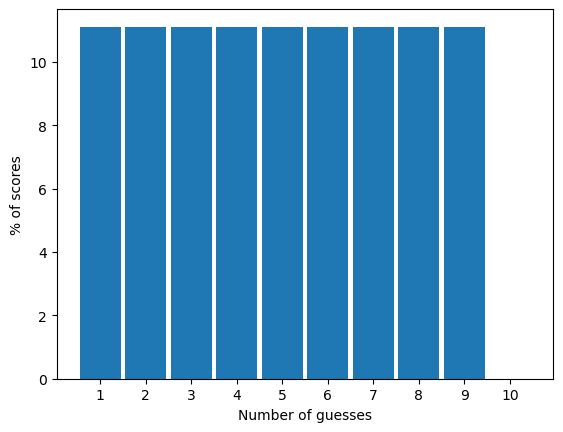

In [31]:
report_minimizing_tree(max, ails)

minimizing the max of partition sizes over 9 targets; inconsistent guesses allowed
first guess: "BERTH"
median: 3 guesses, mean: 2.56 ± 0.53, worst: 3, best: 2
cumulative: ≤2:44%, ≤3:100%, ≤4:100%, ≤5:100%, ≤6:100%, ≤7:100%, ≤8:100%, ≤9:100%, ≤10:100%


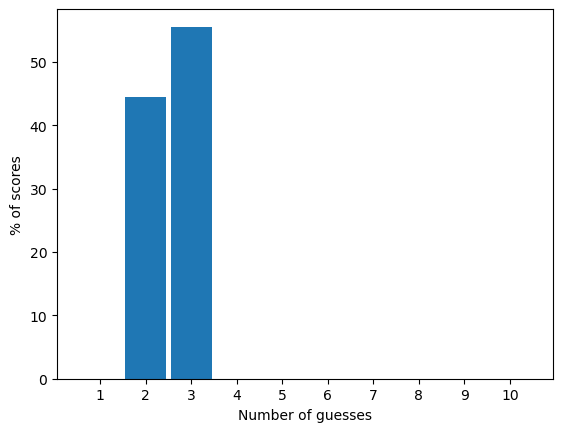

In [32]:
report_minimizing_tree(max, ails, inconsistent=True)

We see that allowing inconsistent guesses improves the mean number of guesses (across all possible targets) from 5.00 to 2.56.

# Reports on Consistent Wordle Guessers

Here are reports on trees made from minimizing each of the three metrics (max, expectation, and entropy), with only consistent guesses allowed: 

minimizing the max of partition sizes over 2,309 targets; inconsistent guesses prohibited
first guess: "ARISE"
median: 4 guesses, mean: 3.68 ± 0.86, worst: 8, best: 1
cumulative: ≤2:5%, ≤3:43%, ≤4:87%, ≤5:97%, ≤6:99.4%, ≤7:99.9%, ≤8:100%, ≤9:100%, ≤10:100%
CPU times: user 3.17 s, sys: 176 ms, total: 3.34 s
Wall time: 1.66 s


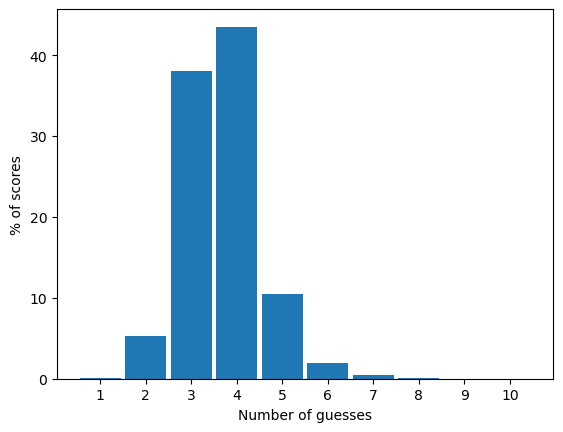

In [33]:
%time report_minimizing_tree(max, inconsistent=False)

minimizing the expectation of partition sizes over 2,309 targets; inconsistent guesses prohibited
first guess: "RAISE"
median: 4 guesses, mean: 3.62 ± 0.86, worst: 8, best: 1
cumulative: ≤2:6%, ≤3:47%, ≤4:88%, ≤5:98%, ≤6:99.4%, ≤7:99.9%, ≤8:100%, ≤9:100%, ≤10:100%
CPU times: user 3.2 s, sys: 277 ms, total: 3.48 s
Wall time: 1.68 s


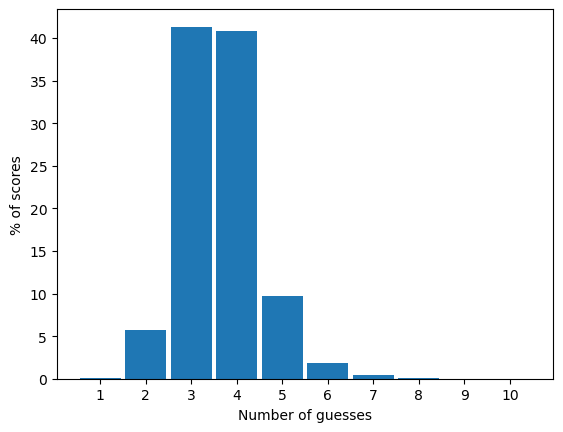

In [34]:
%time report_minimizing_tree(expectation, inconsistent=False)

minimizing the neg_entropy of partition sizes over 2,309 targets; inconsistent guesses prohibited
first guess: "RAISE"
median: 4 guesses, mean: 3.60 ± 0.85, worst: 8, best: 1
cumulative: ≤2:6%, ≤3:49%, ≤4:89%, ≤5:97%, ≤6:99.5%, ≤7:99.9%, ≤8:100%, ≤9:100%, ≤10:100%
CPU times: user 2.92 s, sys: 179 ms, total: 3.1 s
Wall time: 1.88 s


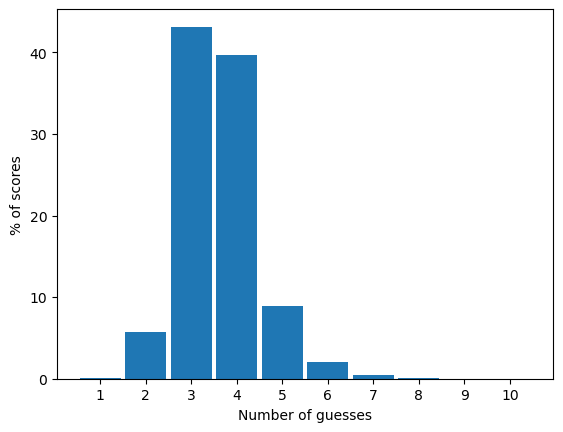

In [35]:
%time report_minimizing_tree(neg_entropy, inconsistent=False)

We see that `neg_entropy` gives the best mean number of guesses, 3.60, and the best winning percentage (99.5% in 6 guesses or less).

The random guesser is also a consistent guesser. Here is a report on it (each run will give slightly different results):

median: 4 guesses, mean: 4.09 ± 1.04, worst: 9, best: 2
cumulative: ≤2:4%, ≤3:29%, ≤4:69%, ≤5:92%, ≤6:98%, ≤7:99.7%, ≤8:99.9%, ≤9:100%, ≤10:100%
CPU times: user 2.88 s, sys: 319 ms, total: 3.2 s
Wall time: 1.6 s


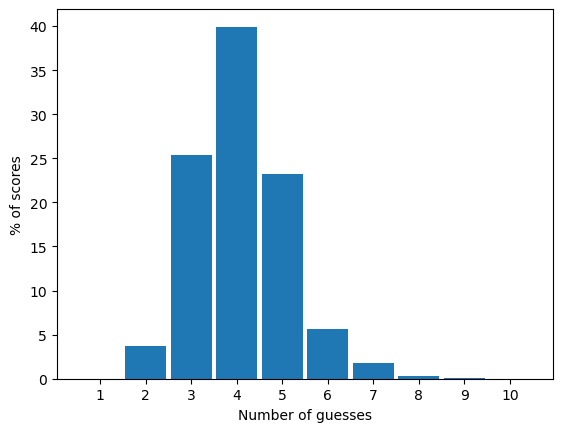

In [36]:
%time report(play(random_guesser, target=target, verbose=False) for target in wordlist)

The random guesser strategy might have seemed hopelessly naive, but it is actually a pretty decent strategy, with mean number of guesses only about 15% worse than the best minimizing tree, and the same median number of guesses, 4. However, it does lose the game (by scoring more than 6) about 2% of the time.

# Reports on Inconsistent Wordle Guessers
Now we'll report on trees with inconsistent guesses allowed. This will take double or triple as much time for each run.

minimizing the max of partition sizes over 2,309 targets; inconsistent guesses allowed
first guess: "ARISE"
median: 4 guesses, mean: 3.64 ± 0.66, worst: 6, best: 1
cumulative: ≤2:2%, ≤3:42%, ≤4:93%, ≤5:99.5%, ≤6:100%, ≤7:100%, ≤8:100%, ≤9:100%, ≤10:100%
CPU times: user 6.35 s, sys: 229 ms, total: 6.58 s
Wall time: 5.25 s


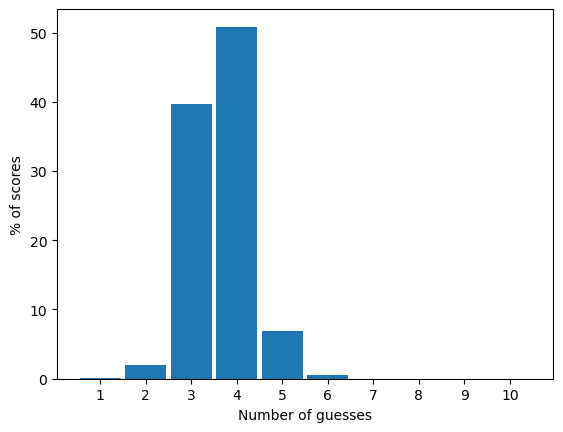

In [37]:
%time report_minimizing_tree(max, inconsistent=True)

minimizing the expectation of partition sizes over 2,309 targets; inconsistent guesses allowed
first guess: "RAISE"
median: 4 guesses, mean: 3.55 ± 0.64, worst: 6, best: 1
cumulative: ≤2:2%, ≤3:48%, ≤4:95%, ≤5:99.6%, ≤6:100%, ≤7:100%, ≤8:100%, ≤9:100%, ≤10:100%
CPU times: user 7.14 s, sys: 223 ms, total: 7.36 s
Wall time: 5.51 s


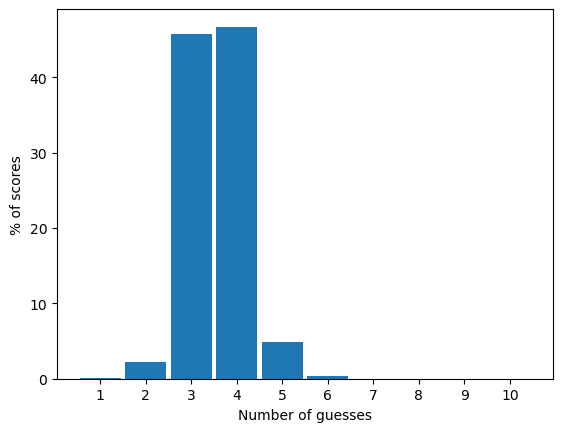

In [38]:
%time report_minimizing_tree(expectation, inconsistent=True)

minimizing the neg_entropy of partition sizes over 2,309 targets; inconsistent guesses allowed
first guess: "RAISE"
median: 3 guesses, mean: 3.52 ± 0.64, worst: 6, best: 1
cumulative: ≤2:2%, ≤3:50%, ≤4:95%, ≤5:99.6%, ≤6:100%, ≤7:100%, ≤8:100%, ≤9:100%, ≤10:100%
CPU times: user 6.88 s, sys: 234 ms, total: 7.11 s
Wall time: 5.72 s


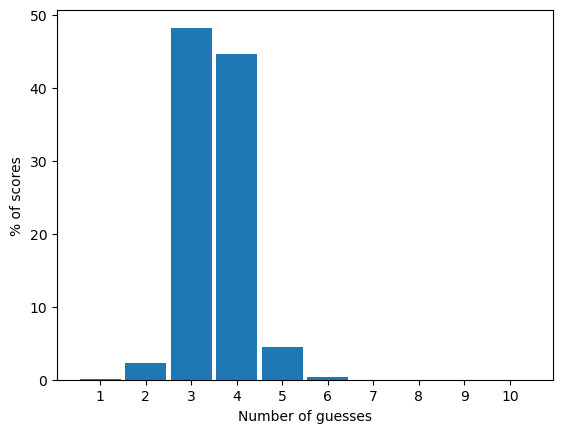

In [39]:
%time report_minimizing_tree(neg_entropy, inconsistent=True)

**Mission accomplished!** With inconsistent guesses allowed, all three metrics  solve  100% of the target words in 6 guesses or less. Again, `neg_entropy` is the best metric by a small amount, giving a mean of 3.52 guesses.



# Best and Worst First Guesses

Below we create a table of the best and worst first guesses (that is, the guesses that score the highest and lowest  according to each of the three metrics):

In [40]:
import pandas as pd

def first_guesses(targets) -> pd.DataFrame: 
    """A data frame of words and scores on the 3 metrics, sorted best to worst on each metric."""
    metrics = (max, expectation, neg_entropy)
    data = [sorted((metric(partition_counts(g, targets)), g) for g in wordlist)
            for metric in metrics]
    def reformat(row):
        (val1, word1), (val2, word2), (val3, word3) = row
        return [word1, val1, word2, round(val2, 2), word3, round(val3, 3)]
    return pd.DataFrame(map(reformat, zip(*data)), 
                        columns='max_word max_score exp_word exp_score ent_word ent_score'.split())

The best and worst first guesses for Wordle:

In [41]:
df = first_guesses(wordlist)
df

,max_word,max_score,exp_word,exp_score,ent_word,ent_score
0,ARISE,167,RAISE,60.74,RAISE,-5.878
1,RAISE,167,ARISE,63.47,SLATE,-5.856
2,ALONE,182,IRATE,63.49,CRATE,-5.835
3,AROSE,182,AROSE,65.76,IRATE,-5.833
4,RATIO,190,ALTER,69.83,TRACE,-5.830
...,...,...,...,...,...,...
2304,CIVIC,1247,PUPPY,775.34,FIZZY,-2.506
2305,PUPPY,1283,MAMMA,776.30,MUMMY,-2.480
2306,MUMMY,1321,VIVID,812.76,MAMMA,-2.398
2307,VIVID,1324,MUMMY,817.96,JAZZY,-2.309


The top guesses are `"RAISE"` and its anagram `"ARISE"`. The letters `'A'`, `'R'`, and `'E'` are the most common in the top guesses. The three metrics agree that `'FUZZY'` is the worst first guess.

Here are the top 20 words for each metric:

In [42]:
df[:20]

,max_word,max_score,exp_word,exp_score,ent_word,ent_score
0,ARISE,167,RAISE,60.74,RAISE,-5.878
1,RAISE,167,ARISE,63.47,SLATE,-5.856
2,ALONE,182,IRATE,63.49,CRATE,-5.835
3,AROSE,182,AROSE,65.76,IRATE,-5.833
4,RATIO,190,ALTER,69.83,TRACE,-5.830
5,ATONE,191,SANER,70.02,ARISE,-5.821
6,IRATE,193,LATER,70.03,STARE,-5.807
7,AISLE,196,SNARE,71.02,SNARE,-5.769
8,ALERT,196,STARE,71.05,AROSE,-5.768
9,ALTER,196,SLATE,71.28,LEAST,-5.752


We see below that partitioning with the guess`'RAISE'` will leave us with no more than 167 words in any branch, while `'FUZZY'` is likely to leave us with a branch of 1349 words, and about 80% of the time will leave us with a branch of 228 words or more.

In [43]:
Counter(partition_counts('RAISE', wordlist))

Counter({1: 28,
         2: 13,
         3: 5,
         4: 10,
         5: 8,
         6: 4,
         7: 3,
         8: 4,
         9: 4,
         10: 2,
         12: 3,
         13: 2,
         14: 1,
         15: 2,
         17: 3,
         18: 2,
         19: 1,
         20: 4,
         21: 2,
         22: 1,
         23: 2,
         24: 1,
         25: 1,
         26: 4,
         28: 2,
         29: 1,
         34: 2,
         35: 1,
         40: 1,
         41: 2,
         43: 1,
         51: 1,
         61: 1,
         69: 1,
         77: 1,
         80: 1,
         91: 2,
         102: 1,
         103: 1,
         107: 1,
         120: 1,
         167: 1})

In [44]:
Counter(partition_counts('FUZZY', wordlist))

Counter({1: 12,
         2: 2,
         3: 1,
         4: 2,
         5: 2,
         6: 1,
         7: 1,
         8: 1,
         10: 2,
         16: 1,
         20: 1,
         45: 1,
         51: 2,
         84: 1,
         122: 1,
         228: 1,
         265: 1,
         1349: 1})

# Evil Wordle

The [**Evil Wordle**](https://swag.github.io/evil-wordle/) variant says it works like this: *"There's no [target] word set by default. Every time you guess, I look at all possible 5-letter words that would fit all your guesses, and choose the match pattern [reply] that results in the most possible words. My goal is to maximize the amount of guesses it takes to find the word."*

To play against Evil Wordle, minimizing the max branch size is a good strategy. We know the guess tree that minimizes max has a few branches that require 6 guesses. If the Evil Replier did look-ahead, perhaps they could force us to one of those branches. But we know that the Evil Replier greedily picks the branch with the "most possible words." So I will define `evil` to follow branches through a guess tree and produce the (guess, reply) pairs along the way. For a given tree, there is only one possible game (assuming the Evil Replier breaks ties the same way each time).

In [45]:
def evil(tree) -> List[Tuple[Word, Reply]]:
    """Given a guess tree, determine what happens when the Evil Replier always picks a maximum-sized branch.
    The result is a list of (guess, reply) tuples."""
    if isinstance(tree, Word):
        return [(tree, Correct)]
    else:
        def size(reply): 
            branch = tree.branches[reply]
            return 0 if reply == Correct else 1 if isinstance(branch, Word) else branch.size
        reply = max(tree.branches, key=size)
        return [(tree.guess, reply)] + evil(tree.branches[reply])

In [46]:
evil(minimizing_tree(max, wordlist, inconsistent=True))

[('ARISE', '.....'),
 ('BLOND', '.....'),
 ('DUMPY', '.YYY.'),
 ('CHUMP', '.GGGG'),
 ('THUMP', 'GGGGG')]

We see that the one possible game consists of 5 guesses. That raises two questions:
- Would it be possible for a smarter Guesser to create a different tree (perhaps minimizing something other than max) that only requires 4 guesses? **No.** I know that because (a) when there are two words left in a branch, it will always take two guesses to defeat the Evil Replier, and (b) I previously tried all two-word guess pairs to see which resulted in the smallest branches, and every pair had branches with multiple words.
- Would it be possible for a smarter Evil Replier to force a game with 6 guesses? **Maybe.** We know the minimizing-max guess tree has 11 out of 2,309 leaves that require 6 guesses. If the Evil Replier did look-ahead instead of acting greedily, could it get to one of those? I think it is unlikely, but I would need to do a minimax search to prove it one way or the other.

Alas, this is all moot, because a little experimenting shows that [**Evil Wordle**](https://swag.github.io/evil-wordle/) is using a word list that contains multiple words that are not in the 2,309 word list. I suspect it is using Wordle's complete 12,971–word list.

# Antiwordle

The Wordle variant [**Antiwordle**](https://www.antiwordle.com/) invites you to *"Avoid guessing the hidden word in as many tries as possible. Sounds easy, but there's a catch!*"  The catch is that only consistent guesses are allowed. We can solve Antiwordle by minimizing the entropy (not negative entropy!) of branch sizes. That is, we want big branches.

minimizing the entropy of partition sizes over 2,309 targets; inconsistent guesses prohibited
first guess: "FUZZY"
median: 6 guesses, mean: 5.75 ± 1.61, worst: 11, best: 1
cumulative: ≤2:1%, ≤3:8%, ≤4:23%, ≤5:44%, ≤6:68%, ≤7:87%, ≤8:96%, ≤9:99%, ≤10:99.7%


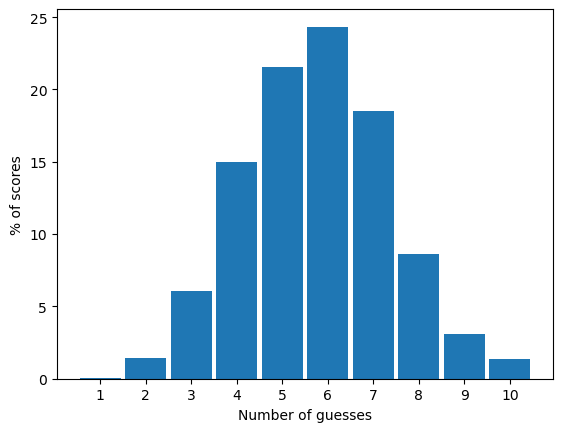

In [47]:
def entropy(counts: List[int]) -> float: return -neg_entropy(counts)

report_minimizing_tree(entropy, inconsistent=False)

We see that, as expected, the "worst" word, `'FUZZY'` is the first guess. Overall, we do pretty well, surviving up to 11 guesses a few times, with a median of 6.

# Jotto

[Jotto](https://en.wikipedia.org/wiki/Jotto) is a venerable word game (invented in 1955) that is quite similar to Wordle. The difference is that the reply in Jotto is an integer from 0 to 5 giving the number of matching letters, with no indication of which letter(s) are correct nor whether they are in the right position or not. There are several variants of Jotto; here are four key questions and my answers (designed to keep things simple):

- How many letters can each word have? **Five**.
- Does a guess have to be a word in the word list? **Yes.**
- Can a word have repeated letters, like the "E" in "ELECT"? **No. Every word must have 5 distinct letters.**
- What if the reply is "5", but the guess is not the target? **Not allowed.**<br>*(E.g., only one of the anagrams APERS/PARES/PARSE/PEARS/REAPS/SPARE/SPEAR  is allowed in the word list.)*

We can make a Jotto word list by:
- Starting with a word list (such as the Wordle list).
- Discarding words that don't have 5 distinct letters.
- Putting the remaining words into a dict of anagrams keyed by the set of letters.
- Keeping only one word for each anagram.

In [48]:
def jotto_allowable(wordlist) -> List[Word]:
    """Build a list of allowable Jotto words from an iterable of words."""
    anagrams = {frozenset(w): w for w in wordlist if len(set(w)) == 5 == len(w)}
    return sorted(anagrams.values())

The right thing to do now would be to refactor the code to allow for the injection of a different `reply_for` function, and a different `wordlist`, so that either game could be played at any time.

However, I'm going to take a shortcut: I'm going to require the programmer to call `setup_game` with the name of the game they want, `'jotto'` or `'wordle'`. This will set global variables accordingly. Notice we mutate `wordlist` rather than rebinding it, because it has already been assigned as a default parameter value in various functions, and we don't want to require the caller to explicitly override those defaults.

In [49]:
wordle_reply_for = reply_for      # Save the original Wordle reply_for function
wordle_wordlist  = list(wordlist) # Save a copy of the original Wordle wordlist, which will be mutated

In [50]:
def jotto_reply_for(guess, target) -> Reply: 
    "The number of letters in common between the target and guess"
    return len(set(target).intersection(guess))

def setup_game(game: str) -> None:
    "Redefine global variables to allow play of either 'jotto' or 'wordle'."
    global histogram_bins, reply_for, Correct
    table = {'wordle': (10, wordle_reply_for, 5 * 'G', wordle_wordlist),
             'jotto':  (16, jotto_reply_for,  5,       jotto_allowable(wordle_wordlist))}
    histogram_bins, reply_for, Correct, wordlist[:] = table[game]

In [51]:
setup_game('jotto')
play(random_guesser)

Guess 1: ZONAL, Reply: 1; Remaining targets: 612
Guess 2: ZESTY, Reply: 1; Remaining targets: 288
Guess 3: FREAK, Reply: 2; Remaining targets: 83
Guess 4: HOMER, Reply: 2; Remaining targets: 35
Guess 5: PLIER, Reply: 1; Remaining targets: 12
Guess 6: BEACH, Reply: 2; Remaining targets: 6
Guess 7: HARDY, Reply: 5; Remaining targets: 1


7

In [52]:
play(random_guesser)

Guess 1: PROUD, Reply: 1; Remaining targets: 594
Guess 2: QUASI, Reply: 1; Remaining targets: 307
Guess 3: FIEND, Reply: 0; Remaining targets: 41
Guess 4: CHART, Reply: 3; Remaining targets: 11
Guess 5: CRAZY, Reply: 2; Remaining targets: 5
Guess 6: MOCHA, Reply: 4; Remaining targets: 2
Guess 7: CHAMP, Reply: 3; Remaining targets: 1
Guess 8: HAVOC, Reply: 5; Remaining targets: 1


8

Below we show that we can switch back to Wordle, and then back to Jotto again, and things still function properly:

In [53]:
setup_game ('wordle')
play(random_guesser)

Guess 1: ANGLE, Reply: .....; Remaining targets: 309
Guess 2: WISPY, Reply: .GG.G; Remaining targets: 4
Guess 3: RISKY, Reply: GGGGG; Remaining targets: 1


3

In [54]:
setup_game('jotto')
play(random_guesser)

Guess 1: SHARK, Reply: 1; Remaining targets: 577
Guess 2: TWANG, Reply: 1; Remaining targets: 250
Guess 3: BRINY, Reply: 2; Remaining targets: 69
Guess 4: GIVER, Reply: 1; Remaining targets: 26
Guess 5: HYMEN, Reply: 2; Remaining targets: 7
Guess 6: MOURN, Reply: 0; Remaining targets: 3
Guess 7: PITHY, Reply: 5; Remaining targets: 1


7

# Reports on Consistent Jotto Guessers

As with Wordle, we'll give reports on the Jotto guessers for various metrics, and for the random guesser:

minimizing the max of partition sizes over 1,391 targets; inconsistent guesses prohibited
first guess: "DRAPE"
median: 6 guesses, mean: 6.31 ± 1.43, worst: 16, best: 1
cumulative: ≤2:0%, ≤3:2%, ≤4:7%, ≤5:24%, ≤6:58%, ≤7:88%, ≤8:95%, ≤9:97%, ≤10:99%
CPU times: user 1.66 s, sys: 40.7 ms, total: 1.7 s
Wall time: 1.54 s


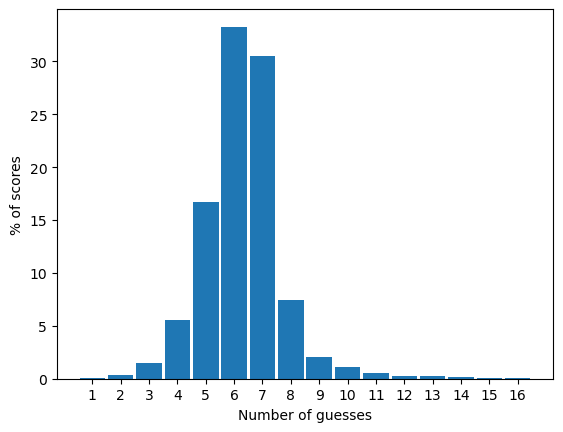

In [55]:
%time report_minimizing_tree(max, inconsistent=False)

minimizing the expectation of partition sizes over 1,391 targets; inconsistent guesses prohibited
first guess: "SOUTH"
median: 6 guesses, mean: 6.11 ± 1.22, worst: 14, best: 1
cumulative: ≤2:0%, ≤3:2%, ≤4:8%, ≤5:26%, ≤6:64%, ≤7:93%, ≤8:98%, ≤9:99%, ≤10:99.5%
CPU times: user 2.29 s, sys: 214 ms, total: 2.51 s
Wall time: 1.48 s


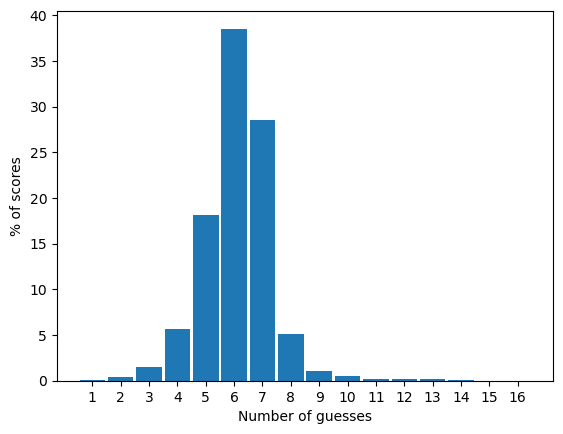

In [56]:
%time report_minimizing_tree(expectation, inconsistent=False)

minimizing the neg_entropy of partition sizes over 1,391 targets; inconsistent guesses prohibited
first guess: "STARE"
median: 6 guesses, mean: 6.31 ± 1.46, worst: 15, best: 1
cumulative: ≤2:0%, ≤3:2%, ≤4:8%, ≤5:25%, ≤6:58%, ≤7:87%, ≤8:95%, ≤9:97%, ≤10:98%
CPU times: user 2.43 s, sys: 177 ms, total: 2.61 s
Wall time: 1.62 s


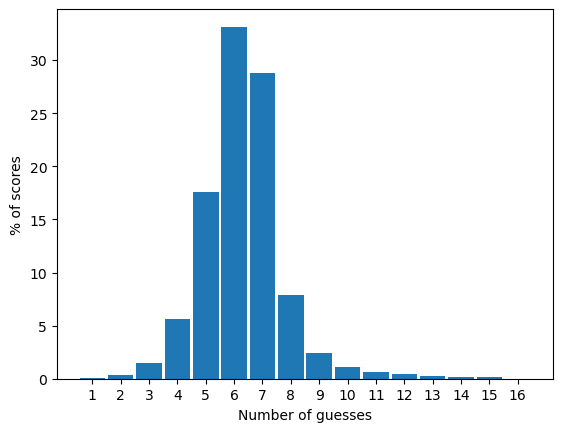

In [57]:
%time report_minimizing_tree(neg_entropy, inconsistent=False)

median: 7 guesses, mean: 6.65 ± 1.46, worst: 13, best: 2
cumulative: ≤2:0%, ≤3:2%, ≤4:7%, ≤5:20%, ≤6:44%, ≤7:75%, ≤8:91%, ≤9:97%, ≤10:99.3%
CPU times: user 2.53 s, sys: 217 ms, total: 2.75 s
Wall time: 1.61 s


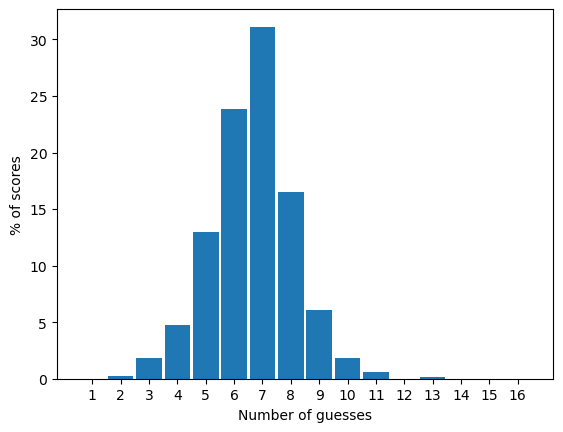

In [58]:
%time report([play(random_guesser, target=target, verbose=False) for target in wordlist])

# Reports on Inconsistent Jotto Guessers

minimizing the max of partition sizes over 1,391 targets; inconsistent guesses allowed
first guess: "DRAPE"
median: 6 guesses, mean: 6.38 ± 0.93, worst: 9, best: 1
cumulative: ≤2:0%, ≤3:1%, ≤4:3%, ≤5:13%, ≤6:52%, ≤7:93%, ≤8:99.8%, ≤9:100%, ≤10:100%
CPU times: user 4.98 s, sys: 51.4 ms, total: 5.03 s
Wall time: 4.83 s


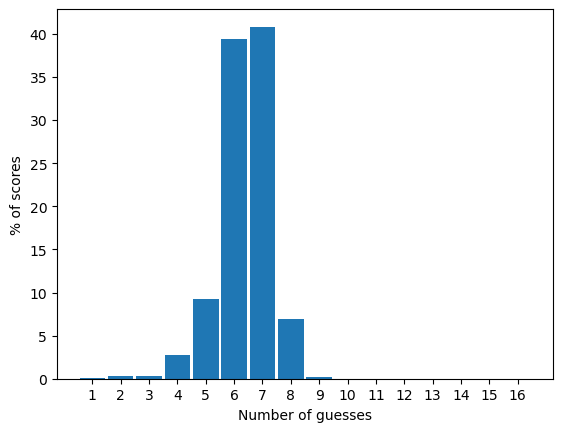

In [59]:
%time report_minimizing_tree(max, inconsistent=True)

minimizing the expectation of partition sizes over 1,391 targets; inconsistent guesses allowed
first guess: "SOUTH"
median: 6 guesses, mean: 6.13 ± 0.89, worst: 9, best: 1
cumulative: ≤2:0%, ≤3:1%, ≤4:4%, ≤5:19%, ≤6:66%, ≤7:97%, ≤8:99.9%, ≤9:100%, ≤10:100%
CPU times: user 5.38 s, sys: 173 ms, total: 5.55 s
Wall time: 4.66 s


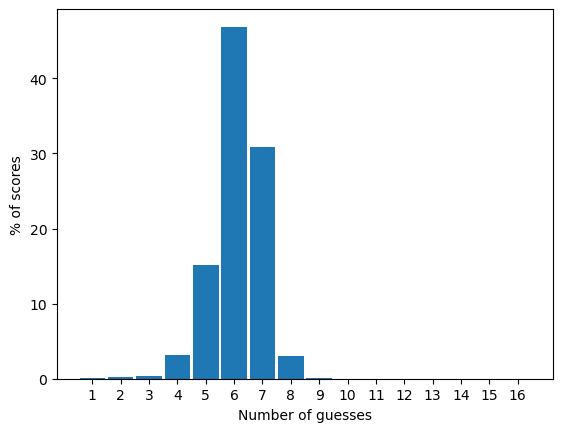

In [60]:
%time report_minimizing_tree(expectation, inconsistent=True)

minimizing the neg_entropy of partition sizes over 1,391 targets; inconsistent guesses allowed
first guess: "STARE"
median: 6 guesses, mean: 6.18 ± 0.93, worst: 9, best: 1
cumulative: ≤2:0%, ≤3:1%, ≤4:3%, ≤5:20%, ≤6:63%, ≤7:95%, ≤8:99.7%, ≤9:100%, ≤10:100%
CPU times: user 6.17 s, sys: 207 ms, total: 6.37 s
Wall time: 4.87 s


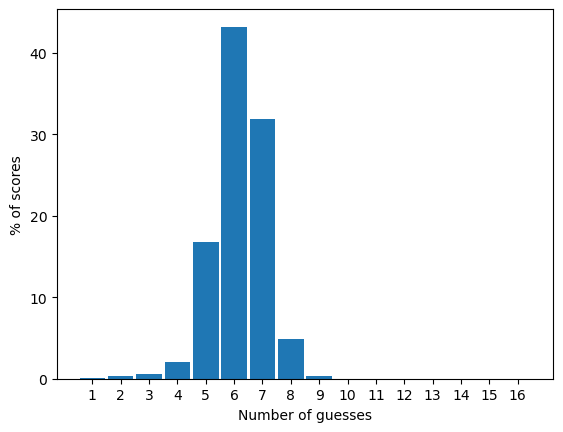

In [61]:
%time report_minimizing_tree(neg_entropy, inconsistent=True)

# Jotto and Wordle Evaluation Summary

Here is a summary of the reports on both games:

|<br><br><br>Algorithm|JOTTO<br>Inonsistent<br><u>Prohibited</u><br>Mean (Max)|JOTTO<br>Inconsistent<br><u>Allowed</u><br>Mean (Max)|WORDLE<br>Inconsistent<br><u>Prohibited</u><br>Mean (Max)|WORDLE<br>Inconsistent<br><u>Allowed</u><br>Mean (Max)||
|--|--|--|--|--|--|
|minimize max        |6.31 (16)|6.38  (9)| 3.68 (8) | 3.64 (6) | 
|minimize expectation|6.11 (14)|6.13  (9)| 3.62 (8) | 3.55 (6) | 
|minimize neg_entropy|6.31 (15)|6.18  (9)| 3.60 (8) | 3.52 (6) |
|random guesser      |6.59 (13)|         | 4.09 (9) |          |


So for both games, the best approach is using the neg-entropy metric and allowing inconsistent guesses.

One surprising thing: allowing inconsistent guesses in Jotto does *not* improve the mean score with eiither the max or expectation metric. However, it does uniformly improve the worst score.


# Jotto Best and Worst First Guesses

Here are the best and worst first guesses for Jotto:

In [62]:
first_guesses(wordlist)

,max_word,max_score,exp_word,exp_score,ent_word,ent_score
0,DRAPE,497,SOUTH,400.50,STARE,-1.971
1,DREAM,497,DEBAR,401.43,CEDAR,-1.964
2,TRASH,497,CRAVE,401.94,DEBAR,-1.961
3,DEBAR,499,STARE,402.56,SPEAR,-1.958
4,DECAL,499,CEDAR,402.94,REACH,-1.958
...,...,...,...,...,...,...
1386,QUAIL,740,AVOID,534.45,QUASI,-1.600
1387,QUAKE,740,QUAKE,534.54,JUICY,-1.587
1388,AVOID,745,QUASI,538.90,JUMPY,-1.564
1389,AUDIO,761,AUDIO,595.22,AXIOM,-1.500


One difference is that in Jotto, most of the best guesses have two vowels, in Wordle three.

`'OUIJA'` is not in our word list, but it was in another list, and it is uniquely bad as a Jotto guess, worse than `'AXIOM'` or `'AUDIO'`. 



# Next Steps

There are many directions you could take this if you are interested:
- **Other games:**
  - Implement [Mastermind](https://en.wikipedia.org/wiki/Mastermind_%28board_game%29). The default version has 6 colors and 4 pegs. Can you go beyond that?
  - Consider a Jotto game variant where each reply consists of two numbers: the number of letters in common with the target, and the number of letters that are in the exact correct position, as in Mastermind.
  - Research what other computer scientists have done with [Jotto](https://arxiv.org/abs/1107.3342) or [Mastermind](http://serkangur.freeservers.com/).
  - There are many variants of Wordle: Evil Wordle, Anti-Wordle, Quordle, Octordle, ...
  - Refactor the code so it can more smoothly handle multiple different games.
- **Better strategy**:
  - Our `minimizing_tree` function is **greedy** in that it guesses the word that minimizes some metric of the current situation without looking ahead to future branches in the tree. Can you get better performance by doing some **look-ahead**? Perhaps with a beam search?
  - As an alternative to look-ahead, can you improve a tree by editing it? Given a tree, look for interior nodes that end up with a worse-than-expected average score, and see if the node can be replaced with something better (covering the same target words). Correcting a few bad nodes might be faster than carefully searching for good nodes in the first place.
  - The three metrics (max, expectation, and negative entropy) are all designed as proxies to what we really want to minimize: the average number of guesses. Can we estimate that directly? For example, we know a branch of size 1 will always take 1 guess; a branch of size 2 an average of 3/2 guesses; and a branch of size 3 an average of 5/3 guesses if one of the words partitions the other two, otherwise an average of 2. Can we learn a function that takes a set of words as input and estimates the average number of guesses for the set? Would a deep neural net be a good way to learn this function?
  - Is it feasible to do a complete search and find the guaranteed optimal strategy? What optimizations to the code would be necessary? Is it worthwhile to port to a different language? How long would the search take?
  - We assume that the list of taregt words is known to the guesser. The [New York Times WordleBot](https://www.nytimes.com/interactive/2022/upshot/wordle-bot.html) initally took this approach too, but then switched to a more nuanced approach where the guesser (the Bot) does not know for sure the list of target words, but instead assigns words a probability of being a target word that is correlated with the word's frequency in English usage. Can you develop a guesser that works along these lines?
- **Chooser strategy**:
  - Analyze the game where the chooser is not random, but rather is an adversary to the guesser–the chooser tries to choose a word that will maximize the guesser's score. What's a good strategy for the chooser? Is there a strategy equilibrium?
  - Refactor `play` to accomodate three roles:
    - A chooser, who decides what the target word is.
    - A guesser, who guesses the target word.
    - A replier, who says what the reply to the guess is.